In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier


In [26]:
df = pd.read_csv("/content/Churn_Modelling.csv")
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [27]:
X = df.drop('Exited', axis=1)
y = df['Exited']


In [28]:
categorical_cols = X.select_dtypes(include='object').columns
numeric_cols = X.select_dtypes(exclude='object').columns


In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)


In [30]:
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [32]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


In [33]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


[[1553   40]
 [ 225  182]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.82      0.45      0.58       407

    accuracy                           0.87      2000
   macro avg       0.85      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000

ROC-AUC Score: 0.8635260838650668


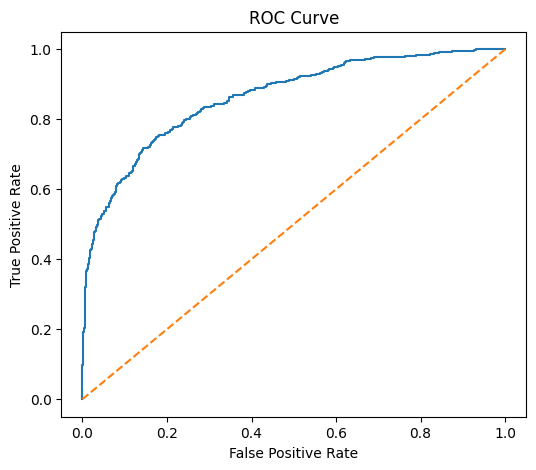

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
